# Classifying common claim severity distributions

The goal of this notebook is to train machine learning models to recognize probability distributions based on a sample of points. For example, let's say we have a list of 10 values that were randomly drawn from a lognormal distribution. We will be able to feed those 10 values into the machine learning model, and it will predict that the sample came from a lognormal distribution. 
The distributions we are interested in classifying are those typically used to model the loss amount of insurance claims:
 - Lognormal 
 - Gamma
 - Weibull
 - Exponential
 - Weibull

**Some libraries**

In [29]:
#Basics
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

#Machine learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

**Generate samples of distributions**

In [30]:
samples_per_dist = 100 #How many samples we will get from each distribution
num_samples = 15 #Number of points in each sample

#Empty arrays with the right dimensions
lognormal_samples = np.empty((samples_per_dist, num_samples))
gamma_samples = np.empty((samples_per_dist, num_samples))
weibull_samples = np.empty((samples_per_dist, num_samples))
exponential_samples = np.empty((samples_per_dist, num_samples))
pareto_samples = np.empty((samples_per_dist, num_samples))

#Variability in the parameters for some of our distributions
params = [np.random.uniform(1, 5) for i in range(0, 4)] #reasonable choice of parameters
a, b, c, s = tuple(params)

#Populating those empty arrays
for i in range(samples_per_dist):
    lognormal_samples[i] = np.sort(st.lognorm.rvs(s=s, size=num_samples)) #We may as well sort the arrays
    gamma_samples[i] = np.sort(st.gamma.rvs(a=a, size=num_samples))
    weibull_samples[i] = np.sort(st.weibull_min.rvs(c=c, size=num_samples))
    exponential_samples[i] = np.sort(st.expon.rvs(size=num_samples))
    pareto_samples[i] = np.sort(st.pareto.rvs(b=b, size=num_samples))

#Stack all of our samples
samples = np.vstack((lognormal_samples, gamma_samples, weibull_samples, exponential_samples, pareto_samples))

**Turn our data into a dataframe**

In [31]:
columns = np.array(['Value' + str(i) for i in range(num_samples)]) #List of columns
total_df = pd.DataFrame(samples, columns=columns) #Create a dataframe
total_df.head()

,Value0,Value1,Value2,Value3,Value4,Value5,Value6,Value7,Value8,Value9,Value10,Value11,Value12,Value13,Value14
0,0.000285,0.026827,0.207034,0.254167,0.424019,0.457478,0.694405,1.323750,1.398439,3.242202,6.447609,10.508668,30.790306,86.653631,1054.900319
1,0.001240,0.001330,0.002480,0.086619,0.163301,0.817221,0.971722,2.074557,3.568635,7.894374,9.904126,20.224873,84.349894,144.398158,3398.921247
2,0.018238,0.018475,0.030857,0.062939,0.101704,0.679859,1.401815,1.527095,3.291663,7.021973,9.959088,11.898181,30.636422,113.368446,265.695487
3,0.009023,0.009122,0.013283,0.036293,0.037420,0.103084,0.137303,1.135937,2.536527,3.000085,6.578882,7.701697,13.137674,14.463970,42.198149
4,0.082763,0.099966,0.132652,0.348331,0.554615,0.825313,1.269769,1.668749,1.725690,2.035759,2.795010,4.060077,4.964953,15.158709,539.643048


**Graphing some of our samples.**

Text(0.5, 1.0, 'Exponential')

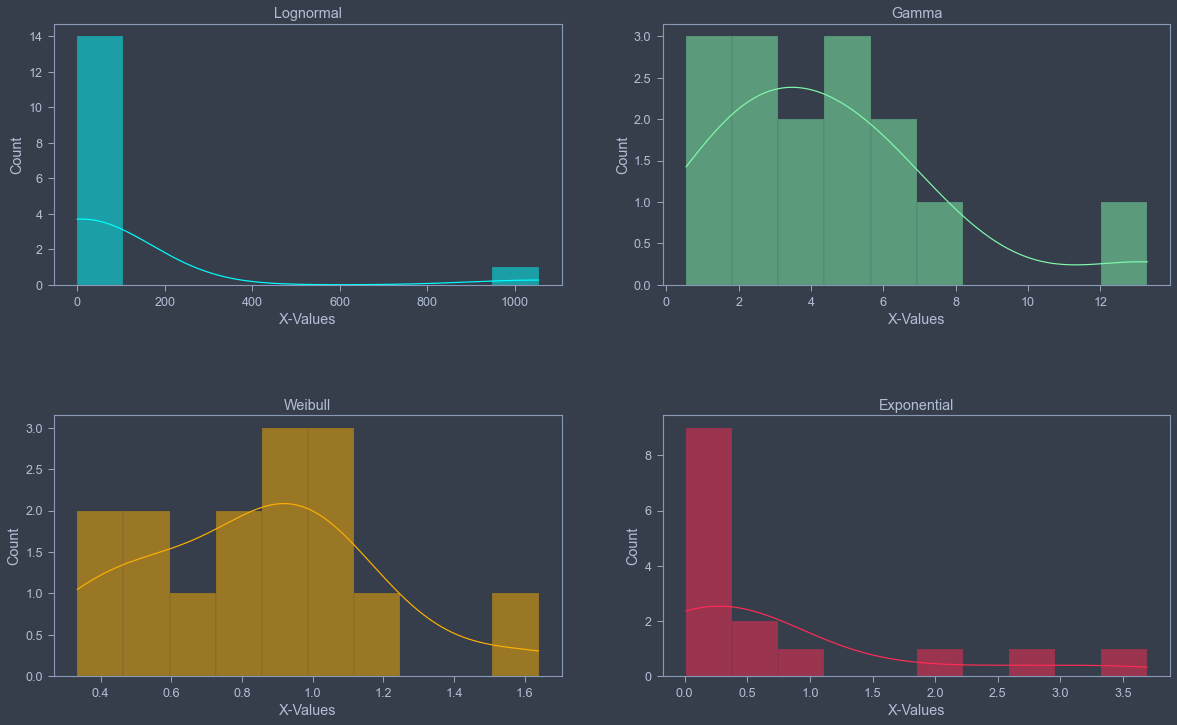

In [32]:
transpose_df = total_df.transpose()
transpose_df.rename(lambda x : 'Sample' + str(x), axis='columns', inplace=True)
num_bins = 10


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
fig.subplots_adjust(hspace=0.5)

for ax in [ax1, ax2, ax3, ax4]: ax.set_xlabel('X-Values')

sns.histplot(data=transpose_df, x='Sample' + str(0 * samples_per_dist), bins=num_bins, ax=ax1, kde=True, color='xkcd:cyan') #Lognormal
ax1.set_title('Lognormal')

sns.histplot(data=transpose_df, x='Sample' + str(1 * samples_per_dist), bins=num_bins, ax=ax2, kde=True, color='xkcd:seafoam') #Gamma
ax2.set_title('Gamma')

sns.histplot(data=transpose_df, x='Sample' + str(2 * samples_per_dist), bins=num_bins, ax=ax3, kde=True, color='xkcd:yellow orange') #Weibull
ax3.set_title('Weibull')

sns.histplot(data=transpose_df, x='Sample' + str(3 * samples_per_dist), bins=num_bins, ax=ax4, kde=True, color='xkcd:reddish pink') #Exponential
ax4.set_title('Exponential')

**Add a distrubition label to each sample**

In [33]:
label_col = np.array([int(a / samples_per_dist) for a in range(5 * samples_per_dist)]) #The label of the distribution for each sample
total_df['Dist'] = label_col #Add the distributions as a column
total_df

,Value0,Value1,Value2,Value3,Value4,Value5,Value6,Value7,Value8,Value9,Value10,Value11,Value12,Value13,Value14,Dist
0,0.000285,0.026827,0.207034,0.254167,0.424019,0.457478,0.694405,1.323750,1.398439,3.242202,6.447609,10.508668,30.790306,86.653631,1054.900319,0
1,0.001240,0.001330,0.002480,0.086619,0.163301,0.817221,0.971722,2.074557,3.568635,7.894374,9.904126,20.224873,84.349894,144.398158,3398.921247,0
2,0.018238,0.018475,0.030857,0.062939,0.101704,0.679859,1.401815,1.527095,3.291663,7.021973,9.959088,11.898181,30.636422,113.368446,265.695487,0
3,0.009023,0.009122,0.013283,0.036293,0.037420,0.103084,0.137303,1.135937,2.536527,3.000085,6.578882,7.701697,13.137674,14.463970,42.198149,0
4,0.082763,0.099966,0.132652,0.348331,0.554615,0.825313,1.269769,1.668749,1.725690,2.035759,2.795010,4.060077,4.964953,15.158709,539.643048,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.007523,1.010458,1.019067,1.037996,1.040003,1.066280,1.080068,1.112558,1.113128,1.144726,1.169216,1.181953,1.558522,1.798976,2.484832,4
496,1.009746,1.009833,1.030109,1.036766,1.053495,1.066475,1.070933,1.092323,1.194812,1.286625,1.458098,1.491318,1.537865,1.581307,1.629671,4
497,1.014040,1.021053,1.044754,1.049283,1.055282,1.077576,1.110070,1.111263,1.177509,1.218511,1.247729,1.284946,1.487883,1.967024,2.552113,4
498,1.002262,1.015200,1.041762,1.048884,1.081158,1.105719,1.107519,1.125059,1.130145,1.296414,1.356808,1.381676,1.421021,1.811153,1.944656,4


**Shuffle data and split into train/test portions**

In [34]:
total_df.sample(frac=1) #Shuffle our dataframe
X = total_df.drop('Dist', axis=1).values #Inputs
y = total_df['Dist'].values #Outputs

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2) #Split into training and testing data

**Try a few machine learning models**

In [35]:
#Logistic regression
logreg = LogisticRegression(solver='lbfgs', max_iter=5000)
logreg.fit(X_train, y_train)
log_acc = round(logreg.score(X_test, y_test) * 100, 2)
log_acc

#Support vector classification
svc = SVC(max_iter=5000)
svc.fit(X_train, y_train)
svc_acc = round(svc.score(X_test, y_test) * 100, 2)
svc_acc

#K-nearest neighbors
knn = KNeighborsClassifier(n_neighbors=50, weights='distance')
knn.fit(X_train, y_train)
knn_acc = round(knn.score(X_test, y_test) * 100, 2)
knn_acc

#Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
gaussian_acc = round(gaussian.score(X_test, y_test) * 100, 2)
gaussian_acc

#Perceptron
perceptron = Perceptron(max_iter=5000)
perceptron.fit(X_train, y_train)
perceptron_acc = round(perceptron.score(X_test, y_test) * 100, 2)
perceptron_acc

#Linear support vector classifier
linear_svc = LinearSVC(max_iter=2000)
linear_svc.fit(X_train, y_train)
linear_svc_acc = round(linear_svc.score(X_test, y_test) * 100, 2)
linear_svc_acc

#Stochastic gradient descent
sgd = SGDClassifier(max_iter=2000)
sgd.fit(X_train, y_train)
sgd_acc = round(sgd.score(X_test, y_test) * 100, 2)
sgd_acc

#Decision tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
decision_tree_acc = round(decision_tree.score(X_test, y_test) * 100, 2)
decision_tree_acc

#Random forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
random_forest_acc = round(random_forest.score(X_test, y_test) * 100, 2)
random_forest_acc

#Print the results
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Descent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [svc_acc, knn_acc, log_acc, 
              random_forest_acc, gaussian_acc, perceptron_acc, 
              sgd_acc, linear_svc_acc, decision_tree_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,97.0
7,Linear SVC,96.0
2,Logistic Regression,95.0
4,Naive Bayes,95.0
8,Decision Tree,94.0
1,KNN,90.0
6,Stochastic Gradient Descent,65.0
0,Support Vector Machines,64.0
5,Perceptron,55.0
